# Introduction
#### One may come up with the idea, "why don't I just use other stocks to predict a stock?"
#### This model does exactly that!
##### The PS (Parallel Stock) model is similar to TA model but using other stock's prices instead.
###### It is essentially copy and pasted but with some minor changes


##### Library Installation

In [1]:
# uncomment this cell to install the following libraries
# follow the below link to use gpu. prefer to use windows native (with tensorflow 2.10) because it is easier to install.
# https://www.tensorflow.org/install/pip
#%pip install numpy
#%pip install pandas
#%pip install ta
#%pip install matplotlib
#%pip install scikit-learn
#%pip install tensorflow
#%pip install ipympl

##### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras import layers
from keras import Input
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from ta import momentum
from ta import volume
from ta import volatility
from ta import trend

from datetime import datetime


##### Miscellaneous

In [3]:
# Used for interactive plots (zooming in)
%matplotlib widget

np.set_printoptions(threshold=np.inf, linewidth=300)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Inputs

In [5]:
# You can predict the price for any stock in the csv file.
stock_to_predict = 'AMZN'

# Data acquisition method

##### Load from file

In [6]:
# Load the csv at the file path
df = pd.read_csv('parallel_stock_data.csv')

# Data Operations

In [7]:
# Convert the 'Date' column to a pandas datetime object (if not already converted)
df['Date'] = pd.to_datetime(df['Date'])

# Drop NaN values, which typically includes the first few rows where TA values are NaN
df.dropna(inplace=True)

In [8]:
print(df.shape)
print(df.columns)
start_date = df['Date'].iloc[0].to_pydatetime().date()
end_date = df['Date'].iloc[-1].to_pydatetime().date()

(2517, 9)
Index(['Date', 'AMZN', 'AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'META',
       'NFLX'],
      dtype='object')


In [9]:
df.isnull().sum()   # check to see if any null values are left.

Date     0
AMZN     0
AAPL     0
MSFT     0
GOOGL    0
TSLA     0
NVDA     0
META     0
NFLX     0
dtype: int64

In [10]:
df_all = df.copy()
df.drop(['Date'], axis=1, inplace=True)

In [11]:
# Swap two columns in the dataframe, only done if the first column is not the stock you are trying to predict.
col_loc = df.columns.get_loc(stock_to_predict)
if col_loc != 0:
    cols = list(df.columns)
    a, b = cols.index(stock_to_predict), cols.index(df.columns[0])
    cols[b], cols[a] = cols[a], cols[b]
    df = df[cols]

In [12]:
df

,AMZN,AAPL,MSFT,GOOGL,TSLA,NVDA,META,NFLX
0,14.9910,16.4643,33.38,22.4274,11.2000,3.9825,44.85,44.2857
1,14.8815,15.9986,33.42,22.2075,11.0053,3.9675,42.50,43.1486
2,15.2030,16.5421,32.99,22.1809,11.1380,3.9675,44.84,42.7086
3,15.6885,16.8107,33.48,22.6724,11.3867,4.0175,45.51,44.0529
4,15.6270,17.0714,33.41,22.4822,11.9267,3.9925,46.32,43.6914
...,...,...,...,...,...,...,...,...
2512,136.8600,178.3500,330.09,134.9100,251.2200,459.4200,299.22,443.5600
2513,138.7500,180.0700,337.24,136.5400,264.2700,461.4800,301.41,443.0700
2514,142.3200,179.4900,335.82,136.2600,270.7600,447.3800,306.33,442.8500
2515,140.9500,176.5100,331.31,135.0900,270.0700,446.0000,302.36,435.5000


In [13]:
# Scale the data
df_columns = df.columns

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df)    # fit and transform to all data
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = df_columns

scaler_price = MinMaxScaler(feature_range=(0, 1))   # fit to data, used by graphs to plot prices instead of values in the (0, 1) range
scaler_price.fit(df[[stock_to_predict]])

scaled_df

,AMZN,AAPL,MSFT,GOOGL,TSLA,NVDA,META,NFLX
0,0.004457,0.002584,0.002703,0.007695,0.008033,0.000602,0.006928,0.002428
1,0.003824,0.000000,0.002825,0.006001,0.007550,0.000572,0.000000,0.000677
2,0.005683,0.003015,0.001519,0.005796,0.007879,0.000572,0.006899,0.000000
3,0.008489,0.004506,0.003007,0.009582,0.008495,0.000672,0.008874,0.002069
4,0.008134,0.005952,0.002794,0.008117,0.009834,0.000622,0.011262,0.001513
...,...,...,...,...,...,...,...,...
2512,0.708984,0.900744,0.903845,0.874135,0.602861,0.914259,0.756884,0.617035
2513,0.719910,0.910287,0.925560,0.886691,0.635202,0.918392,0.763341,0.616281
2514,0.740548,0.907069,0.921248,0.884534,0.651286,0.890105,0.777847,0.615942
2515,0.732628,0.890536,0.907550,0.875521,0.649576,0.887337,0.766142,0.604628


In [14]:
data_all = scaled_df
data_target = scaled_df[[stock_to_predict]]    # Target for prediction. If you want to predict something else, it should be set as the first column.

In [15]:
data_all

,AMZN,AAPL,MSFT,GOOGL,TSLA,NVDA,META,NFLX
0,0.004457,0.002584,0.002703,0.007695,0.008033,0.000602,0.006928,0.002428
1,0.003824,0.000000,0.002825,0.006001,0.007550,0.000572,0.000000,0.000677
2,0.005683,0.003015,0.001519,0.005796,0.007879,0.000572,0.006899,0.000000
3,0.008489,0.004506,0.003007,0.009582,0.008495,0.000672,0.008874,0.002069
4,0.008134,0.005952,0.002794,0.008117,0.009834,0.000622,0.011262,0.001513
...,...,...,...,...,...,...,...,...
2512,0.708984,0.900744,0.903845,0.874135,0.602861,0.914259,0.756884,0.617035
2513,0.719910,0.910287,0.925560,0.886691,0.635202,0.918392,0.763341,0.616281
2514,0.740548,0.907069,0.921248,0.884534,0.651286,0.890105,0.777847,0.615942
2515,0.732628,0.890536,0.907550,0.875521,0.649576,0.887337,0.766142,0.604628


In [16]:
data_target

,AMZN
0,0.004457
1,0.003824
2,0.005683
3,0.008489
4,0.008134
...,...
2512,0.708984
2513,0.719910
2514,0.740548
2515,0.732628


##### Test Data Percent

In [17]:
dataset = scaled_df.to_numpy()     # convert to numpy array. Used for scaling if we ever feel like it
test_data_percent = 0.7   # percentage of data used for testing (no training or validation)
train_data_len = math.ceil(len(dataset) * test_data_percent)

In [18]:
print(len(scaled_df[0:train_data_len]))
print(len(dataset[0:train_data_len]))

1762
1762


##### Train Data Setup

In [19]:
train_x = data_all[0:train_data_len].to_numpy()
train_y = data_target[0:train_data_len].to_numpy()

In [20]:
print(train_x.shape)
print(train_y.shape)

(1762, 8)
(1762, 1)


In [21]:
# preparing the train data as a sliding window
x_train_sw = []
y_train_sw = []

# The sliding window size (in days) we use as input. There are 5 trading days in a week, so 60 trading days = 12 weeks = 3 months
sliding_window_size = 60 
for i in range(sliding_window_size, len(train_x)):
    x_train_sw.append(train_x[i-sliding_window_size:i,:])
    y_train_sw.append(train_y[i:i+1, 0])

x_train_sw, y_train_sw = np.array(x_train_sw), np.array(y_train_sw)   # convert to numpy array

# Transformer Model

In [22]:
def transformer_encoder(
    inputs, 
    head_size, 
    num_heads, 
    ff_dim, 
    dropout=0.0
):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [23]:
# This function builds the model.
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.0,
    mlp_dropout=0.0,
):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)    # this tells us that the output is one prediction step.
    return Model(inputs, outputs)

In [24]:
input_shape = x_train_sw.shape[1:]
print(x_train_sw.shape)     # (number of data values, window, column count)
print(input_shape)          # (window, column count)
print(y_train_sw.shape)     # (number of data values, target)

(1702, 60, 8)
(60, 8)
(1702, 1)


##### Model Checkpoint

In [25]:
# Adding EarlyStopping callback (for lots of epochs)
callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]

# Define the path to save the best weights. The best weights will be used for stock prediction.
checkpoint_path = 'best_weights.h5'

# Adding ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)


##### Model Creation and Training

In [26]:
# The model is ready to be built and trained!
# You can tune the model here.
input_shape = (sliding_window_size, input_shape[1])
model = build_model(
    input_shape,
    head_size=256,
    num_heads=8,
    ff_dim=16,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.05,
    dropout=0.05,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    metrics=['mse', 'mae', 'mape']
)

model.summary()
# CPU
# Weight and Values (ohlcv + 15 TA columns for this chart)
# weight name               weights1    weights2    weights3    weights4    weights5
# head_size                 256         128         512         32
# num_heads                 4           2           2           8
# ff_dim                    4           2           2           8
# num_transformer_blocks    8           2           2           8
# mlp_units                 8           2           2           8
# mlp_dropout               0.25        0.25        0.25        0.25
# dropout                   0.25        0.25        0.25        0.25
###########################################################################################################
# time(may vary)(10 epochs) 7:51        0:30        1:51        3:02
# number of times ran       1           1           3           2
# perf scale 1-10           7           2           2           7

# GPU
# Very fast wow

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 8)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 60, 8)       16          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 60, 8)       71688       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

##### Model Fitting

In [27]:
# Train the model with the callback
train_validation_split = 0.2  # 0.2 means 80% train and 20% validation. Higher = less train, more validation.
history = model.fit(
            x_train_sw,
            y_train_sw,
            validation_split=train_validation_split,
            epochs=30,
            batch_size=128,
            callbacks=[checkpoint]
          )

# Load the best weights into the model
model.load_weights('best_weights.h5')

Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.1194 - mse: 0.1194 - mae: 0.2418 - mape: 42053.3945
Epoch 1: val_loss improved from inf to 0.27789, saving model to best_weights.h5
11/11 [==============================] - 13s 334ms/step - loss: 0.1194 - mse: 0.1194 - mae: 0.2418 - mape: 42053.3945 - val_loss: 0.2779 - val_mse: 0.2779 - val_mae: 0.5126 - val_mape: 95.2998
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.0458 - mse: 0.0458 - mae: 0.1676 - mape: 3155.3855
Epoch 2: val_loss improved from 0.27789 to 0.25511, saving model to best_weights.h5
11/11 [==============================] - 3s 235ms/step - loss: 0.0458 - mse: 0.0458 - mae: 0.1676 - mape: 3155.3855 - val_loss: 0.2551 - val_mse: 0.2551 - val_mae: 0.4874 - val_mape: 90.0915
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.0370 - mse: 0.0370 - mae: 0.1476 - mape: 7246.4829
Epoch 3: val_loss improved from 0.25511 to 0.11383, saving model to best_weights.h5
11/1

# Testing and Validation

##### Test Data Setup

In [28]:
test_x = data_all[train_data_len:].to_numpy()
test_y = data_target[train_data_len:].to_numpy()

In [29]:
print(test_x.shape)
print(test_y.shape)

(755, 8)
(755, 1)


In [30]:
# preparing the test data as a sliding window
x_test_sw = []  # all
y_test_sw = []  # target
y_remaining = []    # all except target

for i in range(sliding_window_size, len(test_x)):
    x_test_sw.append(test_x[i-sliding_window_size:i,:])
    y_test_sw.append(test_y[i:i+1,0])
    y_remaining.append(test_x[i:i+1,1:])

x_test_sw = np.array(x_test_sw)
y_test_sw = np.array(y_test_sw)
y_remaining = np.array(y_remaining)

In [31]:
print(x_test_sw.shape)
print(y_test_sw.shape)
print(y_remaining.shape)
print(y_remaining.size)
print(y_remaining.shape[0])

(695, 60, 8)
(695, 1)
(695, 1, 7)
4865
695


##### Model Evaluation

In [32]:
model.evaluate(x_test_sw, y_test_sw, verbose=1)

 3/22 [===>..........................] - ETA: 0s - loss: 0.0205 - mse: 0.0205 - mae: 0.1365 - mape: 16.0437

22/22 [==============================] - 1s 32ms/step - loss: 0.0149 - mse: 0.0149 - mae: 0.1002 - mape: 14.6818


[0.014939939603209496,
 0.014939939603209496,
 0.10021276772022247,
 14.681825637817383]

##### Performing Prediction Steps

In [33]:
# This function performs a single step prediction and adds supporting values from data for another prediction. Calling this multiple times resembles a multistep model.
# Prediction steps uses ground truth data (except target) per step.
def perform_prediction_step_on_predicted_price(input_data, remaining_y):
    # reshape the input to (1, sliding_window_size, data columns)
    test_input = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))
    #print('####################')
    #print('test input')
    #print(test_input.shape) # (1, sliding_window_size, data columns)

    # perform a prediction step
    prediction_value = model.predict(test_input, verbose=0)
    
    #print('predicted value')
    #print(prediction_value)
    #print('value from test (actual value)')
    #print(input_data[0][0]) # this is the first item (the target) in the first row (before the window gets shifted


    # concatenate the prediction value to beginning of the data columns
    final = np.concatenate((prediction_value, remaining_y), axis=1)

    #print('remaining y')
    #print(remaining_y.shape) # (1, prediction + one row of data columns)

    #print('final')
    #print(final.shape)       # (1, data columns)

    # concatenate the input data to the beginning of
    test_x = np.concatenate((input_data, final), axis=0)

    #print('test_x before shift')
    #print(test_x.shape)     # (1 + sliding_window_size, data columns)

    test_x = test_x[1:]     # shifting the sliding window one step forward

    #print('test_x after shift')
    #print(test_x.shape)     # (sliding_window_size, data columns)
    
    return test_x, prediction_value

In [34]:
# EXPERIMENTAL but it works
# this one is different from the previous in that it allows the model to make predictions on the previous ground truth target, instead on predicting on its old prediction.
# in essence, this allows us to better compare model predictions with the actual value.
def perform_prediction_step_on_actual_price(input_data, remaining_y):
    # reshape the input to (1, sliding_window_size, data columns)
    test_input = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))
    #print('####################')
    #print('test input')
    #print(test_input.shape) # (1, sliding_window_size, data columns)

    # perform a prediction step
    prediction_value = model.predict(test_input, verbose=0)
    
    #print('predicted value')
    #print(prediction_value)
    #print(prediction_value.shape)
    #print('value from test (actual value)')
    last_ground_price = np.reshape(input_data[0][0], (1, 1))
    #print(last_ground_price) # this is the first item (the target) in the first row (before the window gets shifted


    # concatenate the prediction value to beginning of the data columns
    final = np.concatenate((last_ground_price, remaining_y), axis=1)

    #print('remaining y')
    #print(remaining_y.shape) # (1, prediction + one row of data columns)

    #print('final')
    #print(final.shape)       # (1, data columns)

    # concatenate the input data to the beginning of
    test_x = np.concatenate((input_data, final), axis=0)

    #print('test_x before shift')
    #print(test_x.shape)     # (1 + sliding_window_size, data columns)

    test_x = test_x[1:]     # shifting the sliding window one step forward

    #print('test_x after shift')
    #print(test_x.shape)     # (sliding_window_size, data columns)
    
    return test_x, prediction_value

In [35]:
# This function performs a single step prediction without adding supporting values. 
# Only use this if you want to predict a single step into the future!
def perform_prediction_step_tomorrow(input_data):
    test_input = np.reshape(input_data,(1,input_data.shape[0], input_data.shape[1]))
    prediction_value = model.predict(test_input)
    return prediction_value

In [36]:
prediction_values = []
test_x = x_test_sw[0].copy()

# Multistep prediction with the available data
for i in range(y_remaining.shape[0]):
    test_x, prediction = perform_prediction_step_on_actual_price(test_x, y_remaining[i])
    prediction_values.append(prediction)

# Single step prediction into the future!
prediction = perform_prediction_step_tomorrow(test_x)
prediction_values.append(prediction)
print('Today is ' + str(end_date) + '. The next trading day\'s predicted price: $' + str(scaler_price.inverse_transform(prediction)[0][0]))


1/1 [==============================] - 0s 27ms/step
Today is 2023-09-14. The next trading day's predicted price: $190.8373


In [37]:
pred_vals = np.array(prediction_values) # convert to numpy array
pred_vals = pred_vals.squeeze(1)
pred_vals.shape

(696, 1)

##### RMSE

In [38]:
mse = mean_squared_error(pred_vals[:-1], y_test_sw)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.11497716561839562


# Outputs

#### Preparation for Output

In [39]:
# we are concatenating the train data in order to show predicted values on top of ground truth values. This includes the single prediction step into the future.
predicted = np.concatenate((y_train_sw, pred_vals), axis=0)
ground_truth = np.concatenate((y_train_sw, y_test_sw), axis=0)

In [40]:
print(predicted.shape)
print(ground_truth.shape)
print(pred_vals.shape)

(2398, 1)
(2397, 1)
(696, 1)


## Prediction vs Ground Truth Graph

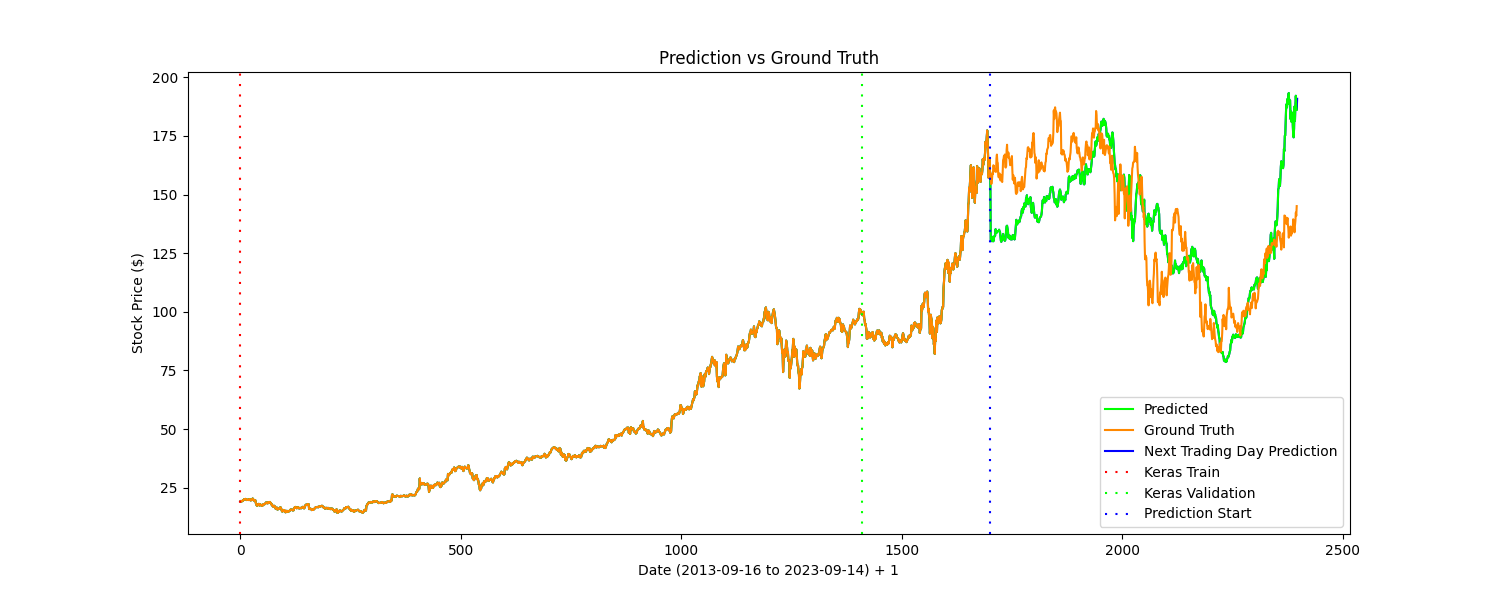

In [41]:
plt.figure(figsize=(15, 6))

# Use the unscaled data to see prices
scaler_pred = scaler_price.inverse_transform(predicted)
scaler_ground_truth = scaler_price.inverse_transform(ground_truth)

#plt.plot(predicted.flatten(), label='Next Trading Day Prediction', color='#0000FF')
#plt.plot(predicted[:-1].flatten(), label='Predicted', color='#00FF00')
#plt.plot(ground_truth.flatten(), label='Ground Truth', color='#FF8800')

# Adding the predicted, ground truth, and tomorrow's prediction
plt.plot(scaler_pred.flatten(), label='Next Trading Day Prediction', color='#0000FF')
plt.plot(scaler_pred[:-1].flatten(), label='Predicted', color='#00FF00')
plt.plot(scaler_ground_truth.flatten(), label='Ground Truth', color='#FF8800')

# Adding vertical lines indicating different data usages
plt.axvline(x=0, label='Keras Train', color='#FF0000', ls=(0, (1, 4)))  # this data was used for model training by keras.
plt.axvline(x=train_data_len * (1-train_validation_split), label='Keras Validation', color='#00FF00', ls=(0, (1, 4)))   # this data was used for model validation by keras.
plt.axvline(x=ground_truth.size-pred_vals.size, label='Prediction Start', color='#0000FF', ls=(0, (1, 4)))   # this is the test data - predictions are made on it, and we can compare it to ground truth.
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0,3,4,5]

plt.xlabel('Date (' + str(start_date) + ' to ' + str(end_date) + ') + 1')
plt.ylabel('Stock Price ($)')
plt.title('Prediction vs Ground Truth')
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
plt.savefig('Prediction.png')
plt.show()


## Daily Stock Returns

In [42]:
df['Daily_Return'] = df[stock_to_predict].pct_change()
df

,AMZN,AAPL,MSFT,GOOGL,TSLA,NVDA,META,NFLX,Daily_Return
0,14.9910,16.4643,33.38,22.4274,11.2000,3.9825,44.85,44.2857,NaN
1,14.8815,15.9986,33.42,22.2075,11.0053,3.9675,42.50,43.1486,-0.007304
2,15.2030,16.5421,32.99,22.1809,11.1380,3.9675,44.84,42.7086,0.021604
3,15.6885,16.8107,33.48,22.6724,11.3867,4.0175,45.51,44.0529,0.031934
4,15.6270,17.0714,33.41,22.4822,11.9267,3.9925,46.32,43.6914,-0.003920
...,...,...,...,...,...,...,...,...,...
2512,136.8600,178.3500,330.09,134.9100,251.2200,459.4200,299.22,443.5600,0.022106
2513,138.7500,180.0700,337.24,136.5400,264.2700,461.4800,301.41,443.0700,0.013810
2514,142.3200,179.4900,335.82,136.2600,270.7600,447.3800,306.33,442.8500,0.025730
2515,140.9500,176.5100,331.31,135.0900,270.0700,446.0000,302.36,435.5000,-0.009626


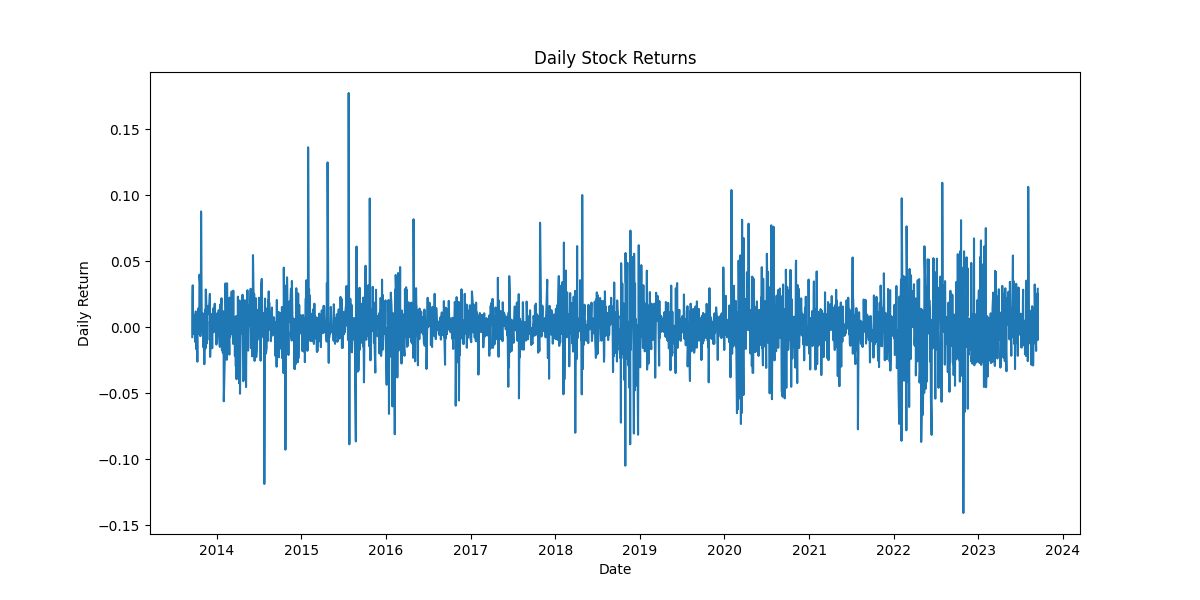

In [43]:
plt.figure(figsize=(12, 6))

# Plotting daily stock returns
plt.plot(df_all['Date'][1:], df['Daily_Return'][1:], linestyle='-')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Stock Returns')
plt.show()

## Loss from Training and Validation

In [44]:
# Accessing training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Generating a list of epochs (x-axis)
epochs = range(1, len(training_loss) + 1)

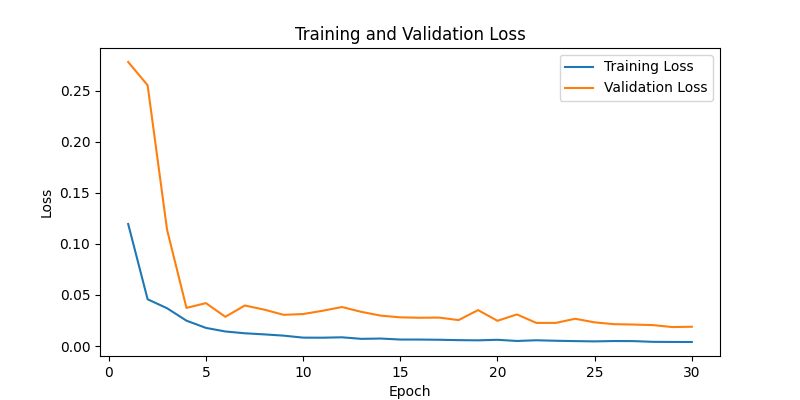

In [45]:
plt.figure(figsize=(8, 4))

# Plotting the training and validation loss over iterations
plt.plot(epochs, training_loss, label='Training Loss', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Pie Chart (Preparation)

In [46]:
# Getting data for pie chart
pie_chart_data = pd.DataFrame({
    'Predicted': pred_vals[:-1].flatten(),  # since the last value is done into the future, it does not have any TA associated with it.
    'Ground_Truth': y_test_sw.flatten()
})

pie_chart_data

,Predicted,Ground_Truth
0,0.673518,0.833475
1,0.673539,0.810669
2,0.678318,0.812886
3,0.669839,0.826280
4,0.674092,0.837267
...,...,...
690,0.966751,0.708984
691,1.004710,0.719910
692,1.028520,0.740548
693,1.002487,0.732628


In [47]:
# Calculating all of the necessary things for the pie chart.

# tolerance = ((pred - gt) / gt) * 100 < tolerance_percent  # determines if the model predicted under some tolerance percent
# gt movement = gtcurr - gtprev > 0                         # determines if the ground truth movement was up or down
# pred movement = pred - gtprev > 0                         # determines if the model prediction was up or down
# if the gt movement and prediction movement are both T or F, then the model predicted correctly upwards/downards.
# if the gt movement and prediction movement are T/F or F/T, then the model predicted incorrectly downwards for T/F and incorrectly upwards for F/T
# if the tolerance is under the %, then the model predicted accurately.
# if the tolerance is over the %, then the model predicted inaccurately.

predicted_values = np.array(pie_chart_data['Predicted'])
ground_truth_values = np.array(pie_chart_data['Ground_Truth'])

tolerance_percent = 2   # integer used to determine if the model was accurate or not. 1 = 1% tolerance
tolerance = []
ground_truth_movement = []  # T is up, F is down
prediction_movement = []    # T is up, F is down

# append bool values to each array based on the requirements
for i in range(1, ground_truth_values.size):
    tolerance.append(True if abs((predicted_values[i] - ground_truth_values[i]) / ground_truth_values[i]) * 100 < tolerance_percent else False)
    ground_truth_movement.append(True if ground_truth_values[i] - ground_truth_values[i-1] > 0 else False)
    prediction_movement.append(True if predicted_values[i] - ground_truth_values[i-1] > 0 else False)

In [48]:
print(len(tolerance))
print(len(ground_truth_movement))
print(len(prediction_movement))

694
694
694


In [49]:
# Categorizations of model movement prediction, ground truth movement, and tolerance 

correct = 0
incorrect = 0
under = 0
over = 0

correct_upwards_under = 0
correct_upwards_over = 0
correct_downwards_under = 0
correct_downwards_over = 0
incorrect_upwards_under = 0
incorrect_upwards_over = 0
incorrect_downwards_under = 0
incorrect_downwards_over = 0

In [50]:
# TODO research a cleaner way of doing this...
for i in range(0, ground_truth_values.size - 1):
    correct += int((ground_truth_movement[i] == True and prediction_movement[i] == True) or (ground_truth_movement[i] == False and prediction_movement[i] == False))     # model predicted correct direction
    incorrect += int((ground_truth_movement[i] == True and prediction_movement[i] == False) or (ground_truth_movement[i] == False and prediction_movement[i] == True))  # model predicted wrong direction
    under += int(tolerance[i] == True)  # model predicted under tolerance
    over += int(tolerance[i] == False)  # model predicted over tolerance

    correct_upwards_under += int(ground_truth_movement[i] == True and prediction_movement[i] == True and tolerance[i] == True)         # model predicted correctly upwards under tolerance
    correct_upwards_over += int(ground_truth_movement[i] == True and prediction_movement[i] == True and tolerance[i] == False)         # model predicted correctly updwards over tolerance
    correct_downwards_under += int(ground_truth_movement[i] == False and prediction_movement[i] == False and tolerance[i] == True)     # model predicted correctly downwards under tolerance
    correct_downwards_over += int(ground_truth_movement[i] == False and prediction_movement[i] == False and tolerance[i] == False)     # model predicted correctly downwards over tolerance
    incorrect_upwards_under += int(ground_truth_movement[i] == False and prediction_movement[i] == True and tolerance[i] == True)      # model predicted incorrectly upwards under tolerance
    incorrect_upwards_over += int(ground_truth_movement[i] == False and prediction_movement[i] == True and tolerance[i] == False)      # model predicted incorrectly upwards over tolerance
    incorrect_downwards_under += int(ground_truth_movement[i] == True and prediction_movement[i] == False and tolerance[i] == True)    # model predicted incorrectly downwards under tolerance
    incorrect_downwards_over += int(ground_truth_movement[i] == True and prediction_movement[i] == False and tolerance[i] == False)    # model predicted incorrectly downwards over tolerance

In [51]:
tol_per = str(tolerance_percent)
print('Number of times the model predicted CORRECT direction: ' + str(correct))
print('Number of times the model predicted INCORRECT direction: ' + str(incorrect))
print('Number of times the model predicted UNDER ' + tol_per + '% tolerance: ' + str(under))
print('Number of times the model predicted OVER ' + tol_per + '% tolerance: ' + str(over))

print('Number of times the model CORRECTLY predicted UPWARD movement UNDER ' + tol_per + '% tolerance: ' + str(correct_upwards_under))
print('Number of times the model CORRECTLY predicted UPWARD movement OVER ' + tol_per + '% tolerance: ' + str(correct_upwards_over))
print('Number of times the model CORRECTLY predicted DOWNWARD movement UNDER ' + tol_per + '% tolerance: ' + str(correct_downwards_under))
print('Number of times the model CORRECTLY predicted DOWNWARD movement OVER ' + tol_per + '% tolerance: ' + str(correct_downwards_over))
print('Number of times the model INCORRECTLY predicted UPWARD movement UNDER ' + tol_per + '% tolerance: ' + str(incorrect_upwards_under))
print('Number of times the model INCORRECTLY predicted UPWARD movement OVER ' + tol_per + '% tolerance: ' + str(incorrect_upwards_over))
print('Number of times the model INCORRECTLY predicted DOWNWARD movement UNDER ' + tol_per + '% tolerance: ' + str(incorrect_downwards_under))
print('Number of times the model INCORRECTLY predicted DOWNWARD movement OVER ' + tol_per + '% tolerance: ' + str(incorrect_downwards_over))

Number of times the model predicted CORRECT direction: 341
Number of times the model predicted INCORRECT direction: 353
Number of times the model predicted UNDER 2% tolerance: 54
Number of times the model predicted OVER 2% tolerance: 640
Number of times the model CORRECTLY predicted UPWARD movement UNDER 2% tolerance: 16
Number of times the model CORRECTLY predicted UPWARD movement OVER 2% tolerance: 126
Number of times the model CORRECTLY predicted DOWNWARD movement UNDER 2% tolerance: 30
Number of times the model CORRECTLY predicted DOWNWARD movement OVER 2% tolerance: 169
Number of times the model INCORRECTLY predicted UPWARD movement UNDER 2% tolerance: 1
Number of times the model INCORRECTLY predicted UPWARD movement OVER 2% tolerance: 135
Number of times the model INCORRECTLY predicted DOWNWARD movement UNDER 2% tolerance: 7
Number of times the model INCORRECTLY predicted DOWNWARD movement OVER 2% tolerance: 210


## Pie Chart

In [52]:
# Helper function to remove zero-percent percentages from the pie chart
def auto_percent(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

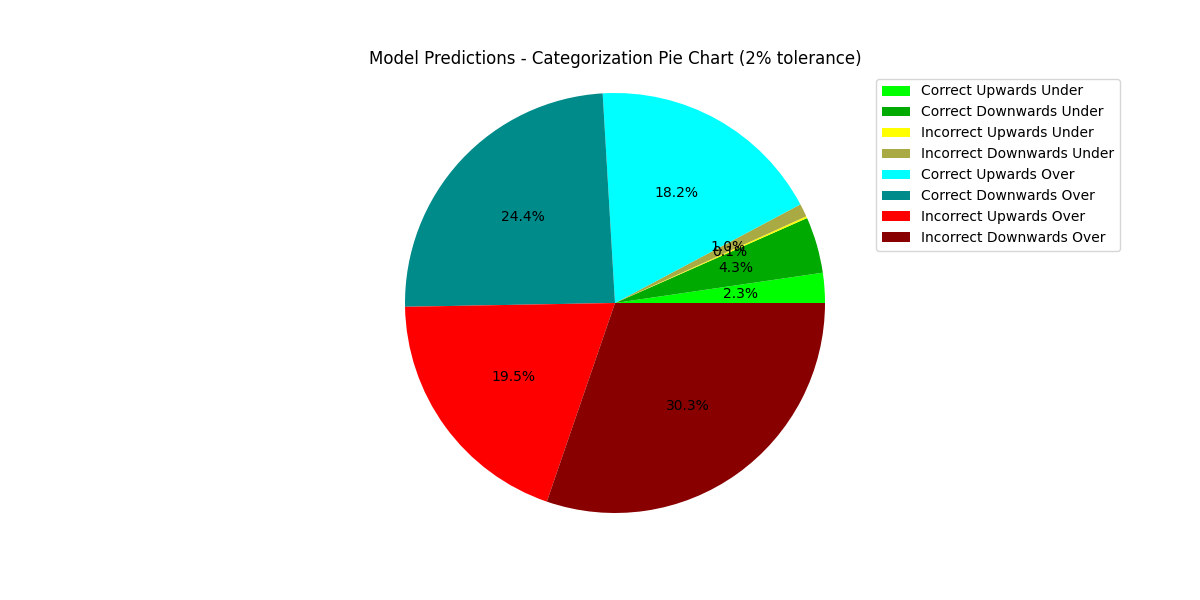

In [53]:
# Data for the pie chart. Use any of these to sort the data by their respective values.
labels_correctness = ['Correct Upwards Under', 'Correct Upwards Over', 'Correct Downwards Under', 'Correct Downwards Over', 'Incorrect Upwards Under', 'Incorrect Upwards Over', 'Incorrect Downwards Under', 'Incorrect Downwards Over']
sizes_correctness = [correct_upwards_under, correct_upwards_over, correct_downwards_under, correct_downwards_over, incorrect_upwards_under, incorrect_upwards_over, incorrect_downwards_under, incorrect_downwards_over]
labels_tolerance = ['Correct Upwards Under', 'Correct Downwards Under', 'Incorrect Upwards Under', 'Incorrect Downwards Under', 'Correct Upwards Over', 'Correct Downwards Over', 'Incorrect Upwards Over', 'Incorrect Downwards Over']
sizes_tolerance = [correct_upwards_under, correct_downwards_under, incorrect_upwards_under, incorrect_downwards_under, correct_upwards_over, correct_downwards_over, incorrect_upwards_over, incorrect_downwards_over]

colors_1 = ['#00FF00', '#00AA00', '#FFFF00', '#AAAA44', '#00FFFF', '#008B8B', '#FF0000', '#880000']

plt.figure(figsize=(12, 6))

# Create the pie chart
plt.pie(sizes_tolerance, labels=labels_tolerance, labeldistance=None, autopct=auto_percent, startangle=0, colors=colors_1)
plt.legend(labels_tolerance, loc='best', bbox_to_anchor=(1.05, 1))
plt.title('Model Predictions - Categorization Pie Chart (' + str(tolerance_percent) + '% tolerance)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [54]:
correctness = [correct, incorrect]
correctness_labels = ['Correct', 'Incorrect']
under_over = [under, over]
under_over_labels = ['Under', 'Over']

colors_2=['#00FF00', '#FF0000']

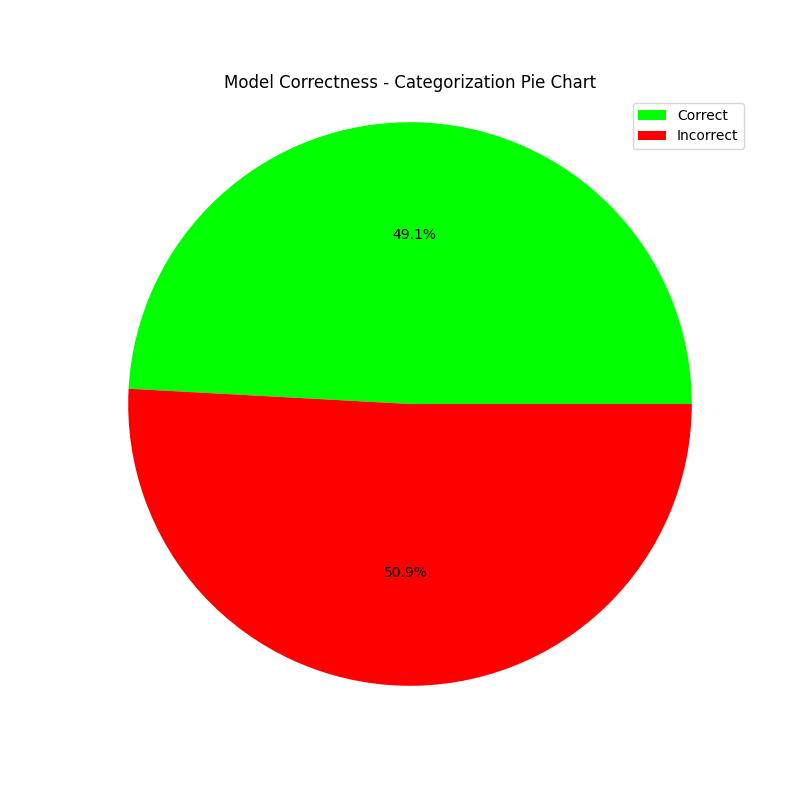

In [55]:
plt.figure(figsize=(8, 8))
plt.pie(correctness, labels=['Correct', 'incorrect'], labeldistance=None, autopct=auto_percent, startangle=0, colors=colors_2)
plt.legend(correctness_labels, loc='best', bbox_to_anchor=(1.05, 1))
plt.title('Model Correctness - Categorization Pie Chart')
plt.axis('equal')
plt.show()

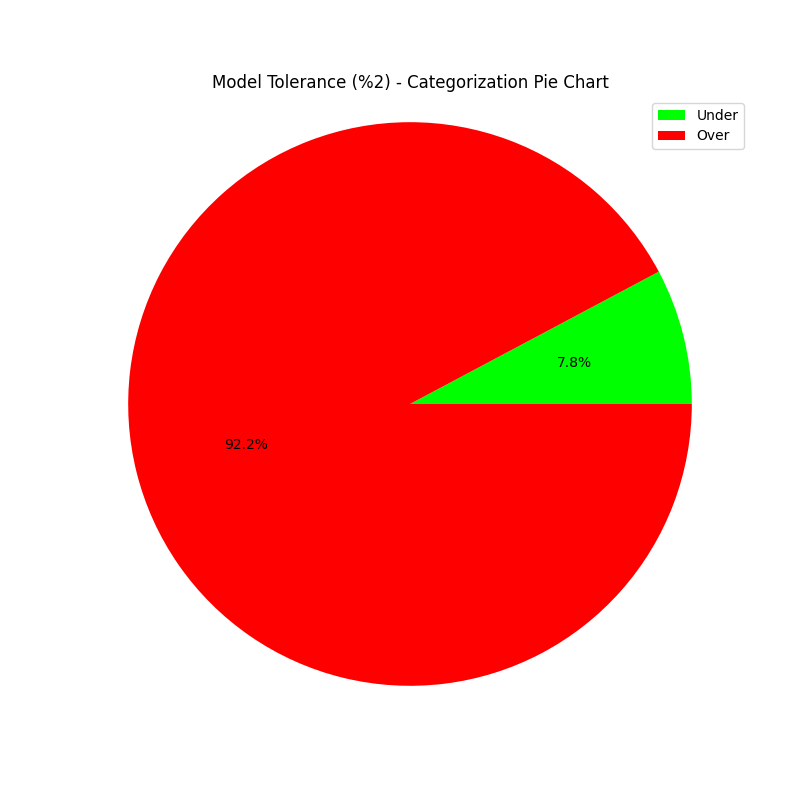

In [56]:
# Under/Over
plt.figure(figsize=(8, 8))
plt.pie(under_over, labels=under_over_labels, labeldistance=None, autopct=auto_percent, startangle=0, colors=colors_2)
plt.legend(under_over_labels, loc='best', bbox_to_anchor=(1.05, 1))
plt.title('Model Tolerance (%' + str(tol_per) + ') - Categorization Pie Chart')
plt.axis('equal')
plt.show()